In [1]:
# import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# for market basket analysis
# conda install -c conda-forge mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

# pip install wordcloud
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

## 1. Text Data Preprocessing

### 1.1 Load the Text Data

In [2]:
dat = pd.read_csv('bbc-text.csv')
dat.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [3]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [4]:
dat["category"].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

### 1.2 Cleanse the Text Data

In [5]:
dat["text"][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [6]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W|_)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

#load a set of stop words
stopwords=get_stop_words("stopwords.txt")

#Remove all punctuations and convert to lower cases
text_all = dat['text'].apply(lambda x:pre_process(x))

In [7]:
#Remove the stop words
from nltk.tokenize import sent_tokenize, word_tokenize

def remove_stopwords(sentence):
    token_words=word_tokenize(sentence)
    new_sentence = [word for word in token_words if word not in stopwords]
    return " ".join(new_sentence)

text_all = text_all.apply(lambda x:remove_stopwords(x))
text_all[0]

'tv future hands viewers home theatre systems plasma definition tvs digital video recorders moving living people watch tv radically five time according expert panel gathered annual consumer electronics las vegas discuss technologies impact favourite pastimes leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front portable devices talked technologies ces digital personal video recorders dvr pvr set top boxes tivo uk sky system allow people record store play pause forward wind tv programmes essentially technology allows personalised tv built definition tv sets business japan slower europe lack definition programming people forward wind adverts forget abiding network channel schedules putting own la carte entertainment networks cable satellite companies worried means terms advertising revenues brand identity viewer loyalty channels leads technology moment concern raised europe particularly growing uptake ser

In [8]:
#Stemming and Lemmatizing
import nltk
#Need to manually download the relevant nltk packages
#nltk.download()
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

def lemSentence(sentence):
    token_words=word_tokenize(sentence)
    lem_sentence=[lem.lemmatize(word) for word in token_words]
    return " ".join(lem_sentence)

text_all = text_all.apply(lambda x:lemSentence(x))
print(text_all[0])

tv future hand viewer home theatre system plasma definition tv digital video recorder moving living people watch tv radically five time according expert panel gathered annual consumer electronics la vega discus technology impact favourite pastime leading trend programme content delivered viewer via home network cable satellite telecom company broadband service provider front portable device talked technology ce digital personal video recorder dvr pvr set top box tivo uk sky system allow people record store play pause forward wind tv programme essentially technology allows personalised tv built definition tv set business japan slower europe lack definition programming people forward wind advert forget abiding network channel schedule putting own la carte entertainment network cable satellite company worried mean term advertising revenue brand identity viewer loyalty channel lead technology moment concern raised europe particularly growing uptake service sky happens nine month time uk ad

In [9]:
text_all.shape

(2225,)

### 1.3 Transform Text Data: Bag-of-Word (Word Count)

In [10]:
#create a vocabulary of words, 
#ignore words that appear in 15% of documents, 
#eliminate stop words
#max_df (ignore words appeared in 15% of documents), max_features(limit the number of words), first. 5000 words
count_vect = CountVectorizer(max_df=0.15, stop_words=stopwords, max_features=5000)

#Fit the data into the model defined early
text_bow = count_vect.fit_transform(text_all.tolist())

In [11]:
text_bow.shape

(2225, 5000)

In [12]:
#sum up all the words that appears
#word_freq -> number of times a certain word appeared in documents (bag of word)

sum_words = text_bow.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [13]:
print('The highest frequency words:')
print(words_freq[0:5])

print('The lowest frequency words:') 
print(words_freq[-5:])

The highest frequency words:
[('film', 1148), ('bn', 958), ('music', 839), ('labour', 804), ('party', 799)]
The lowest frequency words:
[('fenice', 12), ('dundee', 12), ('honda', 12), ('sloncek', 12), ('asimo', 12)]


In [14]:
feature_names=np.array(count_vect.get_feature_names())

#text_all -> text data (after pre-processing)
#text_bow -> word counts (bag of words)
#Each row (0 to 2250) stands for one review
#Each column (0 to 4999) stands for one word frequency appeared in the review.
pd.DataFrame(text_bow.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 Transform Text Data: TF-IDF

In [15]:
#Generate Tf-idf matrix 

tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
text_tfidf = tfidf_transformer.fit_transform(text_bow)

In [16]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['according' 'six' 'public' 'help' 'bn' 'director' 'sale' 'based' 'report'
 'record' 'called' 'life' 'business' 'british' 'international' 'issue'
 'don' 'look' 'start' 'run' 'cost' 'decision' 'despite' 'half' 'london'
 'mean' 'european' 'change' 'film' 'money' 'future' 'result' 're' 'seen'
 'figure' 'spokesman' 'party' 'star' 'lot' 'deal' 'team' 'claim' 'analyst'
 'executive' 'earlier' 'industry' 'action' 'term' 'final' 'britain'
 'share' 'taking' 'able' 'national' 'saying' 'system' 'hope' 'europe'
 'biggest' 'due' 'leader' 'lost' 'recent' 'level' 'technology' 'england'
 'past' 'line' 'office' 'found' 'labour' 'cut' 'january' 'music' 'chance'
 'price' 'website' 'offer' 'following' 'looking' 'programme' 'strong'
 'major' 'job' 'growth' 'ahead' 'election' 'using' 'real' 'believe'
 'michael' 'nation' 'currently' 'hard' 'return' 'rise' 'president'
 'little' 'december' 'playing']


In [17]:
#Each column stands for the tfidf value of a word amongst all documents
#Each row stands for one review
pd.DataFrame(text_tfidf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.04595,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.090775,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# find maximum value for each of the features over dataset:
max_value = text_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

#The higher the tfidf, the more often a word appeared in the document but not very common amongst other documents,
#The word is UNIQUE only in the document.


Features with lowest tfidf:
['etc' 'savvy' 'specification' 'navigate' 'instant' 'sadly' 'status'
 'constantly' 'enforce' 'accepting' 'actual' 'maintaining' 'changing'
 'offline' 'finnish' 'informed' 'tricky' 'dominant' 'amongst'
 'credibility']
Features with highest tfidf: 
['mirza' 'boeing' 'duran' 'feta' 'qantas' 'fiat' 'axa' 'domain' 'mtv'
 'robot' 'mutu' 'dallaglio' 'regiment' 'casino' 'ballet' 'uwb' 'ink'
 'blog' 'nestle' 'commodore']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [19]:
#number of top keywords extracted
topn = 10
results =[]

In [20]:
#Repeating the whole process early but this time for the entire 2250 text to extract top 10 keywords for each of them.
for idx, doc in text_all.items():
    #generate tf-idf for the given document
    tf_idf_vector = text_tfidf[idx]
    
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)
    
    #use only topn items from vector
     
    topn_items = temp[:topn]

    tf_idfs = []
    words = []

    for index, row in topn_items.iterrows():
        #print(int(row['feature_number']))
        fname = feature_names[int(row['feature_number'])]
        words.append(fname)
        #tf_idfs.append(round(row['tf_idf'], 3))

    #result = dict(zip(words, tf_idfs))
    
    results.append(words)

In [21]:
print(len(results))

2225


In [22]:
#Add a new column cleansed_text based on text_all
dat['cleansed_text'] = text_all

#Add a new column keyword based on result (from section 5.2)
dat['keywords'] = results
dat.head()

,category,text,cleansed_text,keywords
0,tech,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...,"[tv, brand, channel, definition, tivo, viewer,..."
1,business,worldcom boss left books alone former worldc...,worldcom bos left book former worldcom bos ber...,"[worldcom, ebbers, accounting, fraud, lawyer, ..."
2,sport,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester rushed bid...,"[farrell, leicester, rugby, league, tiger, uni..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading newcastle fa cup premiership newcastle...,"[league, west, cup, united, drawn, newcastle, ..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...,"[ocean, sequel, twelve, starring, box, office,..."


### 2.2 Association Rule Mining on Keywords - Total

In [23]:
keywords_all = []
for i in results:
    for x in i:
        keywords_all.append(x)

In [24]:
full_list = pd.Series(keywords_all)
full_list

0                tv
1             brand
2           channel
3        definition
4              tivo
            ...    
22245        please
22246        graeme
22247        record
22248        anyway
22249    goalkeeper
Length: 22250, dtype: object

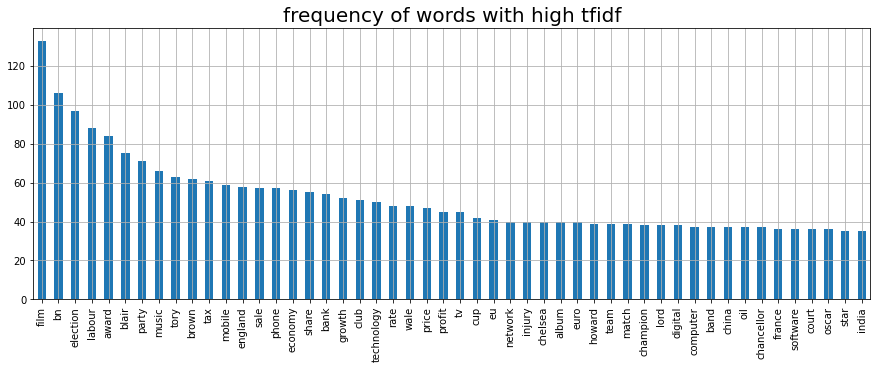

In [25]:
#Frequency of words with high tfidf score
plt.figure(figsize=(15,5))
full_list.value_counts().head(50).plot.bar()
plt.title('frequency of words with high tfidf', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [26]:
from mlxtend.preprocessing import TransactionEncoder

keyword_text = np.array(results)
te = TransactionEncoder()
keyword_encoded = te.fit_transform(keyword_text)
keyword_encoded = pd.DataFrame(keyword_encoded, columns = te.columns_)

# getting the shape of the data
keyword_encoded.shape

(2225, 4145)

In [27]:
#How many keywords that appeared more than 10 times
count = sum([1 for i in full_list.value_counts() if i > 10])
count

455

In [28]:
#Keywords that appeared more than 10 times 
y = full_list.value_counts().to_frame().sort_values(0, ascending=False).head(count)
y.index

Index(['film', 'bn', 'election', 'labour', 'award', 'blair', 'party', 'music',
       'tory', 'brown',
       ...
       'fund', 'celtic', 'rapper', 'parent', 'cash', 'factory', 'paid',
       'common', 'played', 'uefa'],
      dtype='object', length=455)

In [29]:
# getting correlations for 3067 keywords would be messy 
# so let's reduce it from 3067 to 172 first
# these 172 keywords has appeared more than 10 times

keyword_encoded = keyword_encoded.loc[:, y.index]

# checking the shape
keyword_encoded.shape

(2225, 455)

In [30]:
#First, let us return the items and itemsets with at least 1% support:
frequent_keywords=apriori(keyword_encoded, min_support = 0.01, use_colnames = True)

In [31]:
rules_c = association_rules(frequent_keywords, metric="confidence", min_threshold=0.5)
rules_c.sort_values('confidence', ascending = False, inplace = True)
rules_c.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(chancellor),(brown),0.016629,0.027865,0.013483,0.810811,29.097646,0.013020,5.138427
0,(oscar),(film),0.016180,0.059775,0.012135,0.750000,12.546992,0.011168,3.760899
3,(howard),(tory),0.017528,0.028315,0.011685,0.666667,23.544974,0.011189,2.915056
5,(phone),(mobile),0.025618,0.026517,0.015730,0.614035,23.156408,0.015051,2.522206
6,(mobile),(phone),0.026517,0.025618,0.015730,0.593220,23.156408,0.015051,2.395356
2,(labour),(election),0.039551,0.043596,0.022921,0.579545,13.293697,0.021197,2.274692
1,(election),(labour),0.043596,0.039551,0.022921,0.525773,13.293697,0.021197,2.025296
7,(growth),(economy),0.023371,0.025169,0.012135,0.519231,20.630151,0.011547,2.027649


<AxesSubplot:>

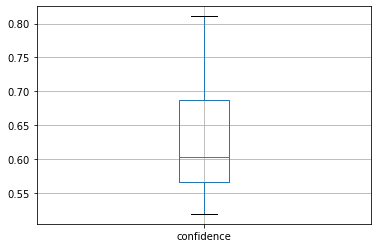

In [32]:
rules_c[['confidence']].boxplot()

### 2.3 Association Rules Mining on Keywords - By category

#### 1. Sports 

In [33]:
#Filter out all sports keywords in a dataframe
sorted_values = dat.query('category=="sport"')['keywords']

keyword_sport = []
for i in sorted_values:
    keyword_sport.append(i)
    
keyword_sport = np.array(keyword_sport)

te_sport = TransactionEncoder()
keyword_sport_encoded = te_sport.fit_transform(keyword_sport)
keyword_sport_encoded = pd.DataFrame(keyword_sport_encoded, columns = te_sport.columns_)

# getting the shape of the data
keyword_sport_encoded.shape



(511, 1481)

In [34]:
frequent_keywords_sport = apriori(keyword_sport_encoded, min_support = 0.018, use_colnames = True)

rules_c_sport = association_rules(frequent_keywords_sport, metric="confidence", min_threshold=0.5)
rules_c_sport.sort_values('confidence', ascending = False, inplace = True)

rules_c_sport[ (rules_c_sport['lift'] > 5)].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(benitez),(liverpool),0.021526,0.045010,0.021526,1.0,22.217391,0.020558,inf
98,"(greek, thanou, test)",(kenteris),0.019569,0.027397,0.019569,1.0,36.500000,0.019033,inf
110,"(kenteris, iaaf, test)",(thanou),0.019569,0.027397,0.019569,1.0,36.500000,0.019033,inf
29,"(greek, iaaf)",(kenteris),0.019569,0.027397,0.019569,1.0,36.500000,0.019033,inf
34,"(greek, iaaf)",(thanou),0.019569,0.027397,0.019569,1.0,36.500000,0.019033,inf
41,"(greek, test)",(kenteris),0.019569,0.027397,0.019569,1.0,36.500000,0.019033,inf
46,"(greek, kenteris)",(thanou),0.023483,0.027397,0.023483,1.0,36.500000,0.022840,inf
47,"(greek, thanou)",(kenteris),0.023483,0.027397,0.023483,1.0,36.500000,0.022840,inf
49,(greek),"(kenteris, thanou)",0.023483,0.027397,0.023483,1.0,36.500000,0.022840,inf
52,"(greek, test)",(thanou),0.019569,0.027397,0.019569,1.0,36.500000,0.019033,inf


<AxesSubplot:>

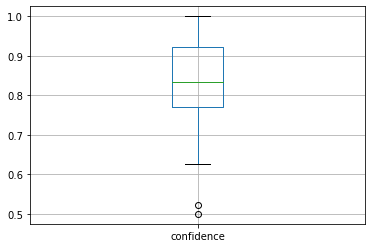

In [35]:
rules_c_sport[['confidence']].boxplot()

#### 2. Business

In [36]:
#Filter out all sports keywords in a dataframe
sorted_values = dat.query('category=="business"')['keywords']

keyword_business = []
for i in sorted_values:
    keyword_business.append(i)
    
keyword_business = np.array(keyword_business)

te_business = TransactionEncoder()
keyword_business_encoded = te_business.fit_transform(keyword_business)
keyword_business_encoded = pd.DataFrame(keyword_business_encoded, columns = te_business.columns_)

keyword_business_encoded.shape

(510, 1595)

In [37]:
frequent_keywords_business = apriori(keyword_business_encoded, min_support = 0.032, use_colnames = True)

rules_c_business = association_rules(frequent_keywords_business, metric="confidence", min_threshold=0.4)
rules_c_business.sort_values('confidence', ascending = False, inplace = True)

rules_c_business[ (rules_c_business['lift'] >= 2) ].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(russian),(yukos),0.043137,0.047059,0.037255,0.863636,18.352273,0.035225,6.988235
7,(yukos),(russian),0.047059,0.043137,0.037255,0.791667,18.352273,0.035225,4.592941
2,(growth),(economy),0.100000,0.103922,0.052941,0.529412,5.094340,0.042549,1.904167
1,(economy),(growth),0.103922,0.100000,0.052941,0.509434,5.094340,0.042549,1.834615
5,(rate),(growth),0.090196,0.100000,0.041176,0.456522,4.565217,0.032157,1.656000
0,(profit),(bn),0.086275,0.188235,0.037255,0.431818,2.294034,0.021015,1.428706
3,(rate),(economy),0.090196,0.103922,0.037255,0.413043,3.974569,0.027882,1.526652
4,(growth),(rate),0.100000,0.090196,0.041176,0.411765,4.565217,0.032157,1.546667


<AxesSubplot:>

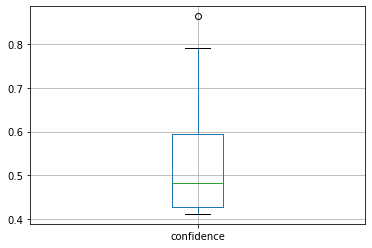

In [38]:
rules_c_business[['confidence']].boxplot()

#### 3. Politics

In [39]:
#Filter out all sports keywords in a dataframe
sorted_values = dat.query('category=="politics"')['keywords']

keyword_politics = []
for i in sorted_values:
    keyword_politics.append(i)
    
keyword_politics = np.array(keyword_politics)

te_politics = TransactionEncoder()
keyword_politics_encoded = te_politics.fit_transform(keyword_politics)
keyword_politics_encoded = pd.DataFrame(keyword_politics_encoded, columns = te_politics.columns_)

keyword_politics_encoded.shape

(417, 1416)

In [40]:
frequent_keywords_politics = apriori(keyword_politics_encoded, min_support = 0.05, use_colnames = True)

rules_c_politics = association_rules(frequent_keywords_politics, metric="confidence", min_threshold=0.4)
rules_c_politics.sort_values('confidence', ascending = False, inplace = True)

rules_c_politics[ (rules_c_politics['lift'] >= 2) ].head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(prime),(blair),0.064748,0.172662,0.052758,0.814815,4.719136,0.041578,4.467626
3,(chancellor),(brown),0.088729,0.122302,0.071942,0.810811,6.629571,0.061091,4.639260
10,(howard),(tory),0.088729,0.151079,0.062350,0.702703,4.651223,0.048945,2.855461
4,(brown),(chancellor),0.122302,0.088729,0.071942,0.588235,6.629571,0.061091,2.213087
8,(labour),(election),0.206235,0.218225,0.119904,0.581395,2.664196,0.074898,1.867573
7,(election),(labour),0.218225,0.206235,0.119904,0.549451,2.664196,0.074898,1.761771
6,(brown),(labour),0.122302,0.206235,0.064748,0.529412,2.567031,0.039525,1.686751
5,(brown),(election),0.122302,0.218225,0.059952,0.490196,2.246283,0.033263,1.533481
9,(party),(election),0.167866,0.218225,0.079137,0.471429,2.160283,0.042504,1.479033
13,(tory),(labour),0.151079,0.206235,0.067146,0.444444,2.155039,0.035988,1.428777


<AxesSubplot:>

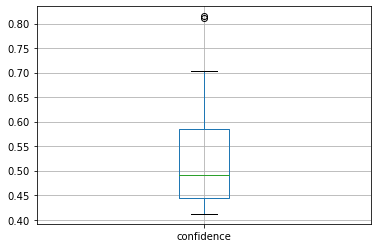

In [41]:
rules_c_politics[['confidence']].boxplot()

#### 4. Tech

In [42]:
#Filter out all sports keywords in a dataframe
sorted_values = dat.query('category=="tech"')['keywords']

keyword_tech = []
for i in sorted_values:
    keyword_tech.append(i)
    
keyword_tech = np.array(keyword_tech)

te_tech = TransactionEncoder()
keyword_tech_encoded = te_tech.fit_transform(keyword_tech)
keyword_tech_encoded = pd.DataFrame(keyword_tech_encoded, columns = te_tech.columns_)

keyword_tech_encoded.shape

(401, 1253)

In [43]:
frequent_keywords_tech = apriori(keyword_tech_encoded, min_support = 0.028, use_colnames = True)

rules_c_tech = association_rules(frequent_keywords_tech, metric="confidence", min_threshold=0.4)
rules_c_tech.sort_values('confidence', ascending = False, inplace = True)

rules_c_tech.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(handset),(mobile),0.052369,0.132170,0.047382,0.904762,6.845463,0.040460,9.112219
8,"(phone, handset)",(mobile),0.042394,0.132170,0.037406,0.882353,6.675916,0.031803,7.376559
1,(handset),(phone),0.052369,0.124688,0.042394,0.809524,6.492381,0.035864,4.595387
7,"(mobile, handset)",(phone),0.047382,0.124688,0.037406,0.789474,6.331579,0.031499,4.157731
3,(spam),(mail),0.039900,0.054863,0.029925,0.750000,13.670455,0.027736,3.780549
9,(handset),"(phone, mobile)",0.052369,0.084788,0.037406,0.714286,8.424370,0.032966,3.203242
4,(phone),(mobile),0.124688,0.132170,0.084788,0.680000,5.144906,0.068308,2.711970
5,(mobile),(phone),0.132170,0.124688,0.084788,0.641509,5.144906,0.068308,2.441659
2,(mail),(spam),0.054863,0.039900,0.029925,0.545455,13.670455,0.027736,2.112219
6,"(phone, mobile)",(handset),0.084788,0.052369,0.037406,0.441176,8.424370,0.032966,1.695761


<AxesSubplot:>

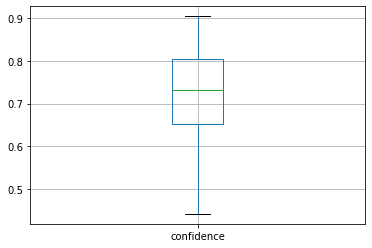

In [44]:
rules_c_tech[['confidence']].boxplot()

#### 5. Entertainment    

In [45]:
#Filter out all sports keywords in a dataframe
sorted_values = dat.query('category=="entertainment"')['keywords']

keyword_entertainment = []
for i in sorted_values:
    keyword_entertainment.append(i)
    
keyword_entertainment = np.array(keyword_entertainment)

te_entertainment = TransactionEncoder()
keyword_entertainment_encoded = te_entertainment.fit_transform(keyword_entertainment)
keyword_entertainment_encoded = pd.DataFrame(keyword_entertainment_encoded, columns = te_entertainment.columns_)

keyword_entertainment_encoded.shape

(386, 1396)

In [46]:
frequent_keywords_entertainment = apriori(keyword_entertainment_encoded, min_support = 0.03, use_colnames = True)

rules_c_entertainment = association_rules(frequent_keywords_entertainment, metric="confidence", min_threshold=0.5)
rules_c_entertainment.sort_values('confidence', ascending = False, inplace = True)

rules_c_entertainment.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(cinema),(film),0.031088,0.326425,0.031088,1.000000,3.063492,0.020940,inf
12,(movie),(film),0.041451,0.326425,0.038860,0.937500,2.872024,0.025330,10.777202
6,(office),(box),0.033679,0.056995,0.031088,0.923077,16.195804,0.029169,12.259067
2,(aviator),(film),0.041451,0.326425,0.033679,0.812500,2.489087,0.020148,3.592401
4,(prize),(award),0.049223,0.186528,0.038860,0.789474,4.232456,0.029679,3.863990
11,(festival),(film),0.067358,0.326425,0.051813,0.769231,2.356532,0.029826,2.918826
13,(oscar),(film),0.093264,0.326425,0.069948,0.750000,2.297619,0.039504,2.694301
14,"(award, oscar)",(film),0.041451,0.326425,0.031088,0.750000,2.297619,0.017558,2.694301
1,(actress),(film),0.049223,0.326425,0.036269,0.736842,2.257310,0.020202,2.559585
9,(single),(chart),0.059585,0.075130,0.038860,0.652174,8.680660,0.034383,2.659003


<AxesSubplot:>

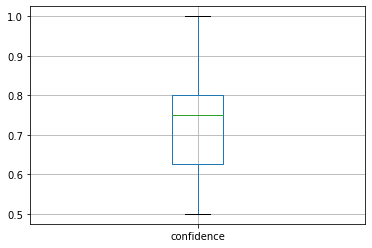

In [47]:
rules_c_entertainment[['confidence']].boxplot()

## 3. Classification Modeling - Word Count

### 3.1 Logistic Regression

#### 3.1.1 Sample the data

In [48]:
#X is the input, the word counts for each word in the document
X = text_bow.toarray()

#Y is the answer(for which category the text belong to)
#convert the sentiment to 0s and 1s
'''
1 sport           
2 business         
3 politics         
4 tech             
5 entertainment  
'''  
y = dat['category'].map( {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5} ).astype(int)

In [49]:
from sklearn.model_selection import train_test_split 
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%) 
# Set the random state as 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

#### 3.1.2 Build the Model 

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#model: LogisticRegression(solver='ibfgs', max_iter=1000)
#Running the model 5 times, getting 5 accuracy scores
log_model = LogisticRegression(solver='lbfgs', max_iter=1000)
log_model.fit(X_train, y_train)


training_scores = cross_val_score(log_model, X_train, y_train, cv=5)
print(training_scores)
training_score = np.mean(training_scores)

#Getting the mean of the five scores.
print("(Logistic Reg) Mean training accuracy: {:.1f}%".format(training_score*100))

[0.94871795 0.9775641  0.95498392 0.96463023 0.9807074 ]
(Logistic Reg) Mean training accuracy: 96.5%


#### 3.1.3 Evaluate the Model

Text(0.5, 1.0, 'Accuracy Score: 0.975')

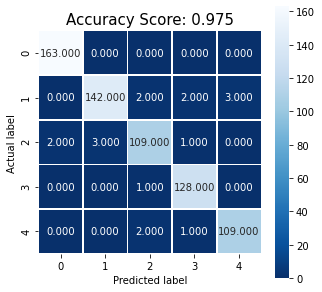

In [51]:
#Using Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

predictions = log_model.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions)


plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15)

#### 3.1.4 Improve the Model using GridSearchCV

In [52]:
#GridSearchCV is the process of performing hyperparameter tuning in order to determine the optimal values for a given model
from sklearn.model_selection import GridSearchCV

#Cfloat, default=1.0
#Reversed of regularization, must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(log_model, param_grid, cv=5, n_jobs=5)
grid.fit(X_train, y_train)

#Getting the mean of the five scores.
print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

#Accuracy score 
acc_score = grid.score(X_test, y_test)
print("Testing accuracy score:  {:.1f}%".format(acc_score*100))

Optimized cross validation training accuracy: 96.7%
Best parameters:  {'C': 10}
Testing accuracy score:  97.6%


### 3.2 SGD Classifier

In [53]:
#SGDClassifier is a Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss="hinge", random_state=42)
sgd_model.fit(X_train, y_train)

training_scores = cross_val_score(sgd_model, X_train, y_train, cv=5)
print(training_scores)
training_score = np.mean(training_scores)

#Getting the mean of the five scores.
print("(Linear SVM classifier) Mean training accuracy: {:.1f}%".format(training_score*100))

[0.91987179 0.97115385 0.94212219 0.95819936 0.95498392]
(Linear SVM classifier) Mean training accuracy: 94.9%


In [54]:

param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3] #learning rate 
             }

grid = GridSearchCV(sgd_model, param_grid=param_grid, cv=5, n_jobs=5) 
grid.fit(X_train, y_train)

#Getting the mean of the five scores.
print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

acc_score = grid.score(X_test, y_test)
print("Testing accuracy score:  {:.1f}%".format(acc_score*100))


Optimized cross validation training accuracy: 96.1%
Best parameters:  {'alpha': 1.0}
Testing accuracy score:  97.3%


### 3.3 Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

training_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(training_scores)
training_score = np.mean(training_scores)

#Getting the mean of the five scores.
print("(Random Forest Classifier) Mean training accuracy: {:.1f}%".format(training_score*100))


[0.95512821 0.97115385 0.95176849 0.95819936 0.96463023]
(Random Forest Classifier) Mean training accuracy: 96.0%


In [56]:

param_grid = {
    'max_depth': [20, 40, 60, 80, 100, 120]
}


grid = GridSearchCV(rf_model, param_grid=param_grid, cv=5, n_jobs=5,) 
grid.fit(X_train, y_train)

#Getting the mean of the five scores.
print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

acc_score = grid.score(X_test, y_test)
print("Testing accuracy score:  {:.1f}%".format(acc_score*100))


Optimized cross validation training accuracy: 96.1%
Best parameters:  {'max_depth': 40}
Testing accuracy score:  97.0%


## 3. Classification Modeling (Use Tf-Idf matrix as model input)

### 3.1 Logistic Regression

#### 3.1.1 Sample the data

In [57]:
X2 = text_tfidf.toarray()

'''
1 sport           
2 business         
3 politics         
4 tech             
5 entertainment  
'''  
y = dat['category'].map( {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5} ).astype(int)

In [58]:
# Split both Inputs (X2) and Ouput (y) into training set (70%) and testing set (30%)

X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=2)

#### 3.1.2 Build the Model 

In [59]:
log_model2 = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class="multinomial")
log_model2.fit(X2_train, y_train)

training_scores2 = cross_val_score(log_model2, X2_train, y_train, cv=5)
print(training_scores2)
training_score2 = np.mean(training_scores2)

#Getting the mean of the five scores.
print("(Logistic Reg2) Mean training accuracy: {:.1f}%".format(training_score2*100))

[0.95512821 0.98717949 0.95498392 0.97106109 0.9807074 ]
(Logistic Reg2) Mean training accuracy: 97.0%


#### 3.1.3 Evaluate the Model

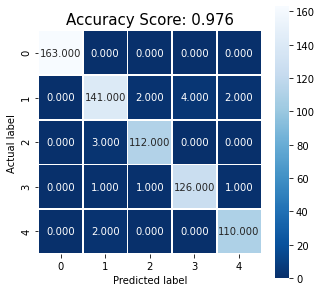

In [60]:
#Using Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

predictions = log_model2.predict(X2_test)

cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

#### 3.1.4 Improve the Model using GridSearchCV

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [0.01, 0.1, 1, 10]}

grid = GridSearchCV(log_model2, param_grid, cv=5, n_jobs=5)
grid.fit(X2_train, y_train)

print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

#Accuracy score 
acc_score = grid.score(X2_test, y_test)
print("Testing accuracy score:  {:.1f}%".format(acc_score*100))

Optimized cross validation training accuracy: 97.1%
Best parameters:  {'C': 10}
Testing accuracy score:  97.9%


In [62]:
predictions = grid.predict(X2_test)
metrics.accuracy_score(y_test, predictions)

0.9790419161676647

### 3.2 SGD Classifier

In [63]:
#SGDClassifier is a Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
from sklearn.linear_model import SGDClassifier

sgd_model2 = SGDClassifier(loss="hinge", random_state=42)
sgd_model2.fit(X2_train, y_train)

training_scores2 = cross_val_score(sgd_model2, X2_train, y_train, cv=5)
print(training_scores2)
training_score2 = np.mean(training_scores2)
#Getting the mean of the five scores.

print("(Linear SVM classifier2) Mean training accuracy: {:.1f}%".format(training_score2*100))

[0.95192308 0.98076923 0.96141479 0.97106109 0.97427653]
(Linear SVM classifier2) Mean training accuracy: 96.8%


In [64]:
param_grid = {
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2] #learning rate ]
}

grid = GridSearchCV(sgd_model2, param_grid, cv=5, n_jobs=-1) 
grid.fit(X2_train, y_train)

#Getting the mean of the five scores.
print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

acc_score = grid.score(X2_test, y_test)
print("Testing accuracy score:  {:.1f}%".format(acc_score*100))

Optimized cross validation training accuracy: 96.8%
Best parameters:  {'alpha': 0.0001}
Testing accuracy score:  97.3%


### 3.3 Random Forest Classifier

In [65]:
from sklearn.ensemble import RandomForestClassifier

rf_model2 = RandomForestClassifier(random_state=42)
rf_model2.fit(X2_train, y_train)

training_scores2 = cross_val_score(rf_model2, X2_train, y_train, cv=5)
print(training_scores2)
training_score2 = np.mean(training_scores2)

#Getting the mean of the five scores.
print("(Random Forest Classifier2) Mean training accuracy: {:.1f}%".format(training_score2*100))


[0.96153846 0.97115385 0.94855305 0.95498392 0.95819936]
(Random Forest Classifier2) Mean training accuracy: 95.9%


In [86]:
param_grid = {
    "max_depth": [20, 40, 60, 80, 100, 120]
}


grid = GridSearchCV(rf_model2, param_grid=param_grid, cv=5, n_jobs=-1) 
grid.fit(X2_train, y_train)

#Getting the mean of the five scores.
print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

acc_score = grid.score(X2_test, y_test)

print("Testing accuracy score:  {:.1f}%".format(acc_score*100))


Optimized cross validation training accuracy: 96.1%
Best parameters:  {'max_depth': 60}
Testing accuracy score:  96.3%


## Further Improvements 

### Trying out Naive Bayes Classifier to see if can achieve higher performance

#### 1. Naive Bayes Classifier using word count as input

In [124]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

training_scores = cross_val_score(nb, X_train, y_train, cv=5)
print(training_scores)
training_score = np.mean(training_scores)

#Getting the mean of the five scores.
print("(Naive Bayes Classifier) Mean training accuracy: {:.1f}%".format(training_score*100))


[0.95512821 0.98717949 0.96463023 0.96784566 0.97749196]
(Naive Bayes Classifier) Mean training accuracy: 97.0%


In [125]:

param_grid = {
    "alpha": [1, 1.5, 2, 3, 5, 10]
}


grid = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=5) 
grid.fit(X_train, y_train)

#Getting the mean of the five scores.
print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

acc_score = grid.score(X_test, y_test)

print("Testing accuracy score:  {:.1f}%".format(acc_score*100))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Optimized cross validation training accuracy: 97.2%
Best parameters:  {'alpha': 2}
Testing accuracy score:  96.7%


#### 2. Naive Bayes Classifier using TF-IDF matrix as input

In [88]:
from sklearn.naive_bayes import MultinomialNB

nb2 = MultinomialNB()
nb2.fit(X2_train, y_train)

training_scores2 = cross_val_score(nb2, X2_train, y_train, cv=5)
print(training_scores2)
training_score2 = np.mean(training_scores2)

#Getting the mean of the five scores.
print("(Naive Bayes Classifier) Mean training accuracy: {:.1f}%".format(training_score2*100))


[0.95192308 0.98717949 0.96141479 0.97106109 0.9807074 ]
(Naive Bayes Classifier) Mean training accuracy: 97.0%


In [94]:
param_grid = {
    "alpha": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1]
}


grid = GridSearchCV(nb2, param_grid=param_grid, cv=5, n_jobs=-1) 
grid.fit(X2_train, y_train)

#Getting the mean of the five scores.
print("Optimized cross validation training accuracy: {:.1f}%".format(grid.best_score_*100))
print("Best parameters: ", grid.best_params_)

acc_score = grid.score(X2_test, y_test)

print("Testing accuracy score:  {:.1f}%".format(acc_score*100))

Optimized cross validation training accuracy: 97.4%
Best parameters:  {'alpha': 0.02}
Testing accuracy score:  97.0%
